Text mining - Sentiment

dataset:https://www.kaggle.com/datasets/kashishparmar02/social-media-sentiments-analysis-dataset/data

In [ ]:
pip install twython

In [ ]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
pip install colorama

In [ ]:
pip install transformers torch

In [ ]:
pip install transformers torch plotly

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, init
import plotly.express as px
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from transformers import pipeline
import pandas as pd
from sklearn.svm import SVC
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df = pd.read_csv("sentimentdataset.csv")

Data preprocessing

In [ ]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Compile regex patterns
URL_PATTERN = re.compile(r'https?://\S+|www\.\S+')
BRACKET_PATTERN = re.compile(r'\[.*?\]')
HTML_PATTERN = re.compile(r'<.*?>')
PUNCTUATION_PATTERN = re.compile(f'[{re.escape(string.punctuation)}]')
DIGITS_PATTERN = re.compile(r'\w*\d\w*')
NON_ASCII_PATTERN = re.compile(r'[^\x00-\x7F]')
REPEATED_CHAR_PATTERN = re.compile(r'(.)\1{2,}')  # Matches repeated characters

def clean(text):
    text = str(text).lower()
    text = BRACKET_PATTERN.sub('', text)
    text = URL_PATTERN.sub('', text)
    text = HTML_PATTERN.sub('', text)
    text = PUNCTUATION_PATTERN.sub(' ', text)
    text = DIGITS_PATTERN.sub('', text)
    text = NON_ASCII_PATTERN.sub('', text)
    text = REPEATED_CHAR_PATTERN.sub(r'\1\1', text)  # Reduce repeated characters

    # Strip whitespace and remove extra spaces
    text = ' '.join(text.split())

    # Tokenization
    tokens = word_tokenize(text)
    # Lemmatization and filtering
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Join cleaned tokens back into a single string
    cleaned_text = ' '.join(cleaned_tokens)

    return cleaned_text

df["Clean_Text"] = df["Text"].apply(clean)

In [ ]:
sentiment_analyzer = pipeline("sentiment-analysis")

def analyze_sentiment(text):
    result = sentiment_analyzer(text)[0]
    # Return label and score, ensuring we handle neutral cases
    return result['label'], result['score']

# Apply sentiment analysis
df['Sentiment'], df['Score'] = zip(*df['Clean_Text'].apply(analyze_sentiment))

# Adjust sentiment labels to ensure neutral is captured
df['Sentiment'] = df['Sentiment'].replace({'POSITIVE': 'positive', 'NEGATIVE': 'negative'})

# Add custom logic to classify neutral sentiments based on score
df['Sentiment'] = df.apply(lambda row: 'neutral' if row['Score'] < 0.05 and row['Score'] > -0.05 else row['Sentiment'], axis=1)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
df[['Clean_Text', 'Score', 'Sentiment']].head()

,Clean_Text,Score,Sentiment
0,enjoying beautiful day park,0.999884,positive
1,traffic terrible morning,0.998275,negative
2,finished amazing workout,0.999782,positive
3,excited upcoming weekend getaway,0.999389,positive
4,trying new recipe dinner tonight,0.910479,positive


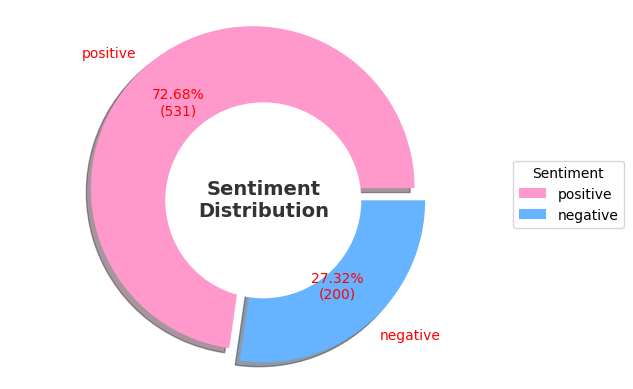

In [ ]:
# Pie chart
sentiment_counts = df['Sentiment'].value_counts()

colors = ['#ff99cc', '#66b3ff']
explode = [0.1] + [0] * (len(sentiment_counts) - 1)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts,
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p * sum(sentiment_counts) / 100)})',
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True
)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')

plt.show()

In [ ]:
# Count common words for visualization
def count_common_words(texts):
    words = [word for text in texts for word in text.lower().split()]
    return Counter(words)

# Count common words in the original text
top_words = count_common_words(df['Clean_Text'])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

# Plotting the common words using Plotly
fig = px.bar(top_words_df,
             x="count",
             y="Common_words",
             title='Common Words in Customer Reviews',
             orientation='h',
             width=700,
             height=700,
             color='count',
             color_continuous_scale='Viridis')

fig.update_layout(yaxis_title='Common Words', xaxis_title='Count', title_font_size=20)
fig.show()


In [ ]:
Positive_sent = df[df['Sentiment'] == 'positive']
Negative_sent = df[df['Sentiment'] == 'negative']


In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize the text
    tokens = text.split()
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens  # Return a list of processed words

In [ ]:
df['temp_list'] = df['Clean_Text'].apply(preprocess_text)

In [ ]:
def get_common_words(sentiment, color_map):
    top = Counter([item for sublist in df[df['Sentiment'] == sentiment]['temp_list'] for item in sublist])
    common_words_df = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
    return common_words_df.style.background_gradient(cmap=color_map)

sentiment_info = [
    ('positive', 'Greens'),
    ('negative', 'Reds')
]

results = {}

for sentiment, color in sentiment_info:
    results[sentiment] = get_common_words(sentiment, color)

for sentiment, styled_df in results.items():
    print(f"Common words for {sentiment} sentiment:")
    display(styled_df)

Common words for positive sentiment:


,Common_words,count
0,new,37
1,joy,27
2,life,26
3,friend,24
4,laughter,24
5,moment,21
6,beauty,20
7,world,18
8,time,18
9,nature,18


Common words for negative sentiment:


,Common_words,count
0,like,15
1,day,14
2,shattered,13
3,feeling,12
4,life,12
5,despair,12
6,emotion,12
7,echo,12
8,heart,11
9,lost,11


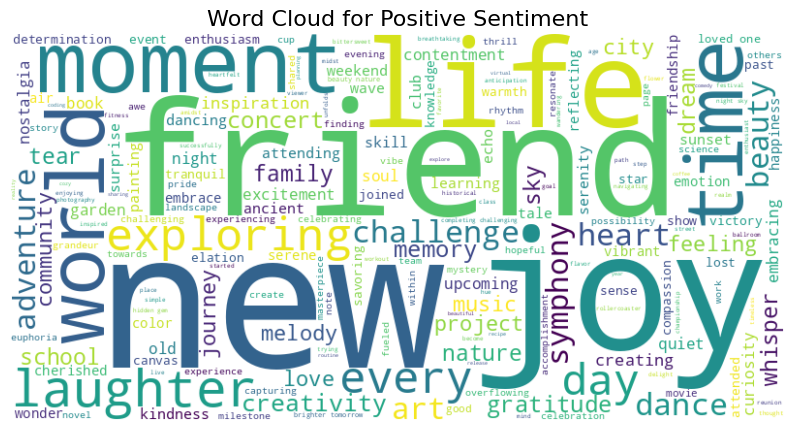

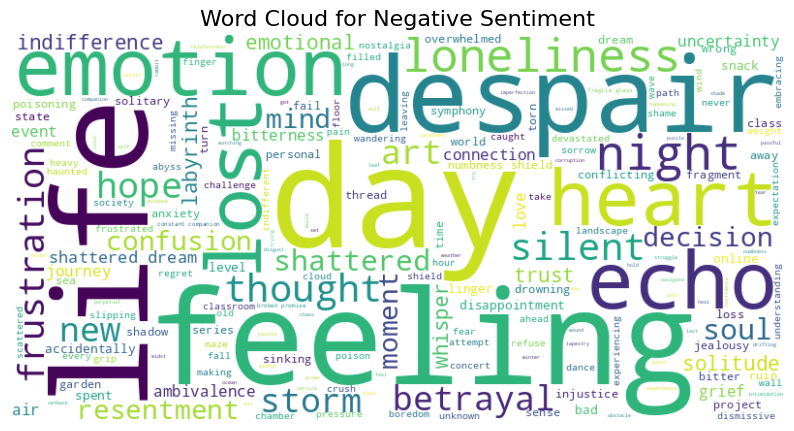

In [ ]:
sentiment_categories = ['positive',  'negative']

# Create word clouds for each sentiment category
for sentiment in sentiment_categories:
    # Join words for the current sentiment
    words = ' '.join([item for sublist in df[df['Sentiment'] == sentiment]['temp_list'] for item in sublist])

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiment', fontsize=16)
    plt.show()

Only SVM

Support Vector Machine Results:
Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.68      0.69        40
    positive       0.88      0.90      0.89       107

    accuracy                           0.84       147
   macro avg       0.80      0.79      0.79       147
weighted avg       0.83      0.84      0.84       147

Sensitivity: 0.90, Specificity: 0.68


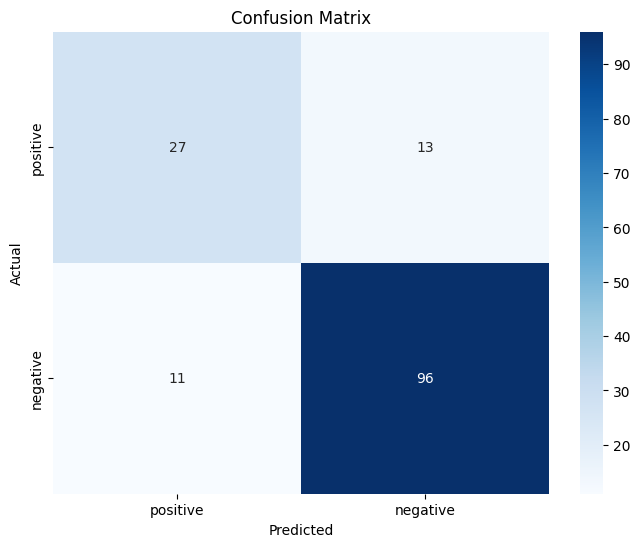

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Splitting the data
X = df['Clean_Text'].values
y = df['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorization
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# GridSearch for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Best estimator
best_svm = grid_search.best_estimator_

# Predictions
y_pred_svm = best_svm.predict(X_test_tfidf)

# Evaluation
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)

# Output results
print("Support Vector Machine Results:")
print(f"Accuracy: {accuracy_svm:.2f}")
print("Classification Report:\n", classification_rep_svm)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)

# Calculate Sensitivity and Specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}")

# Mapping numeric labels back to original sentiment labels
sentiment_labels = ['positive', 'negative']  # Adjust if you have more labels

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sentiment_labels, yticklabels=sentiment_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


SVM & Bert

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Support Vector Machine Results with BERT:
Accuracy: 0.85
Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.68      0.71        40
    positive       0.88      0.92      0.90       107

    accuracy                           0.85       147
   macro avg       0.82      0.80      0.80       147
weighted avg       0.85      0.85      0.85       147

Sensitivity: 0.92, Specificity: 0.68


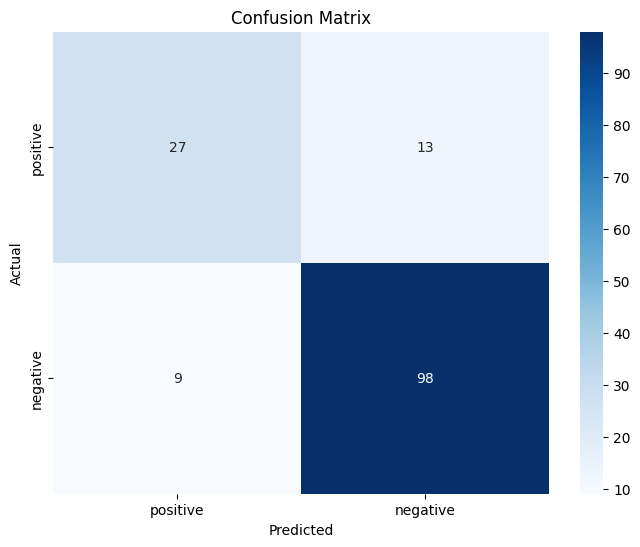

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
X = df['Clean_Text'].values
y = df['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to encode text using BERT
def encode_text(texts):
    inputs = tokenizer(texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the pooled output
    return outputs.pooler_output.numpy()

# Encode the training and test data
X_train_bert = encode_text(X_train)
X_test_bert = encode_text(X_test)

# GridSearch for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_bert, y_train)

# Best estimator
best_svm = grid_search.best_estimator_

# Predictions
y_pred_svm = best_svm.predict(X_test_bert)

# Evaluation
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)

# Output results
print("Support Vector Machine Results with BERT:")
print(f"Accuracy: {accuracy_svm:.2f}")
print("Classification Report:\n", classification_rep_svm)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)

# Calculate Sensitivity and Specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}")

# Mapping numeric labels back to original sentiment labels
sentiment_labels = ['positive', 'negative']  # Adjust if you have more labels

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sentiment_labels, yticklabels=sentiment_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


SVM and PCA

Support Vector Machine Results with PCA:
Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

    negative       0.65      0.75      0.70        40
    positive       0.90      0.85      0.88       107

    accuracy                           0.82       147
   macro avg       0.78      0.80      0.79       147
weighted avg       0.83      0.82      0.83       147

Sensitivity: 0.85, Specificity: 0.75


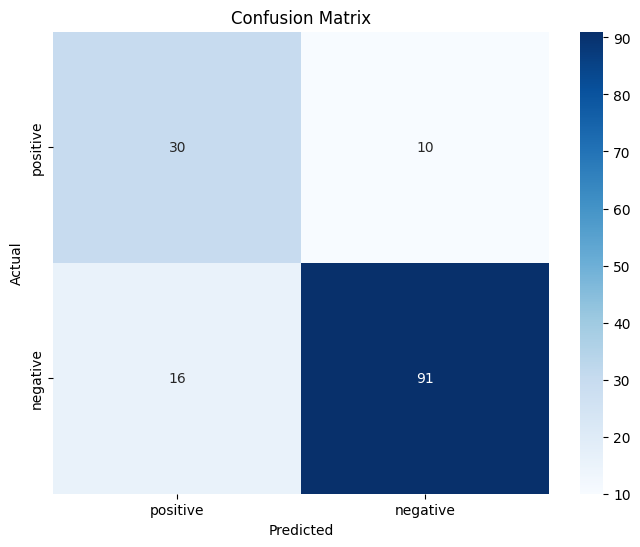

In [ ]:
X = df['Clean_Text'].values
y = df['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline for vectorization, PCA and SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('pca', PCA(n_components=100)),
    ('svm', SVC(random_state=42))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf']
}

# Import GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best estimator
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Output results
print("Support Vector Machine Results with PCA:")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate Sensitivity and Specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}")

# Mapping numeric labels back to original sentiment labels
sentiment_labels = ['positive', 'negative']  # Adjust if you have more labels

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sentiment_labels, yticklabels=sentiment_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


SVM & PCA & BERT

SVM Results with PCA & BERT:
Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.72      0.76        40
    positive       0.90      0.93      0.92       107

    accuracy                           0.88       147
   macro avg       0.85      0.83      0.84       147
weighted avg       0.87      0.88      0.88       147

Sensitivity: 0.72, Specificity: 0.93


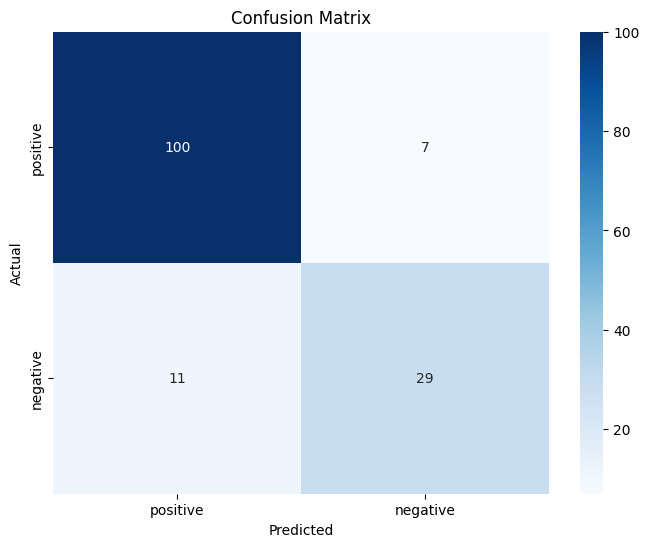

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertModel
import torch

# Prepare data for BERT
X = df['Clean_Text'].values
y = df['Sentiment'].values
y = pd.factorize(y)[0]  # Convert sentiment labels to numeric

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_embeddings(texts):
    inputs = tokenizer(texts.tolist(), truncation=True, padding=True, return_tensors='pt', max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    # Take the mean of the last hidden state as the embedding
    return outputs.last_hidden_state.mean(dim=1).numpy()

# Get embeddings for train and test sets
X_train_embeddings = get_embeddings(X_train)
X_test_embeddings = get_embeddings(X_test)

# Apply PCA to reduce dimensions
pca = PCA(n_components=50)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train_embeddings)
X_test_pca = pca.transform(X_test_embeddings)

# Train SVM with GridSearch for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

# Best estimator
best_svm = grid_search.best_estimator_

# Predictions
y_pred = best_svm.predict(X_test_pca)

# Map numeric predictions to string labels
label_mapping = {0: 'positive', 1: 'negative'}
y_pred_labels = [label_mapping[label] for label in y_pred]
y_test_labels = [label_mapping[label] for label in y_test]

# Evaluation
accuracy = accuracy_score(y_test_labels, y_pred_labels)
classification_rep = classification_report(y_test_labels, y_pred_labels, target_names=['negative', 'positive'])

# Output results
print("SVM Results with PCA & BERT:")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate Sensitivity and Specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}")

# Mapping numeric labels back to original sentiment labels
sentiment_labels = ['positive', 'negative']  # Adjust if you have more labels

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sentiment_labels, yticklabels=sentiment_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


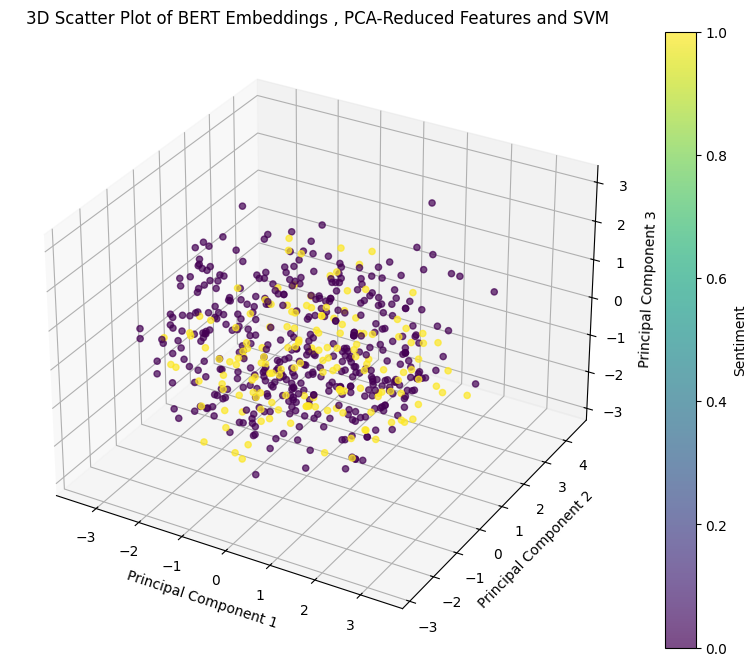

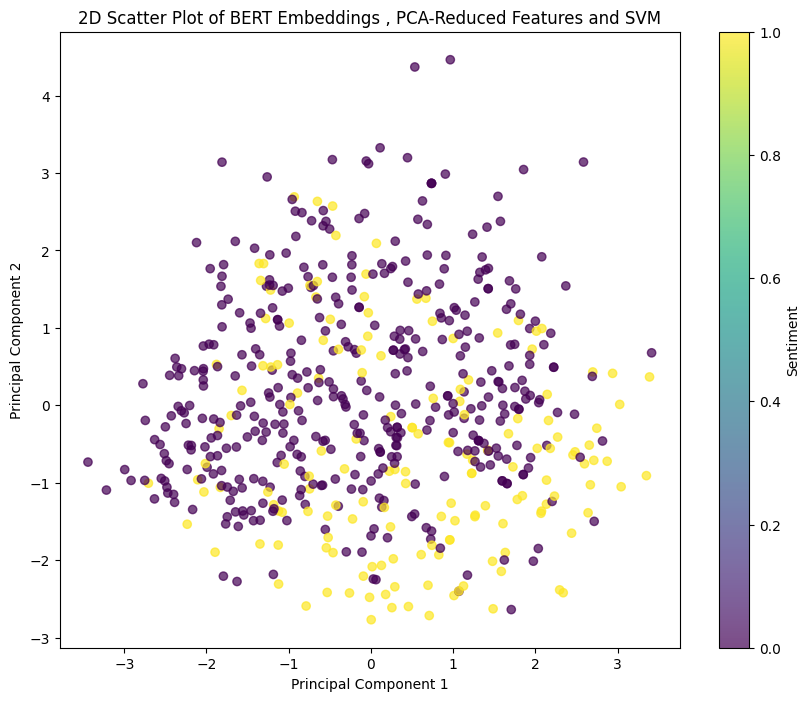

In [ ]:
#Visualize the first three PCA components in a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap='viridis', alpha=0.7)
ax.set_title('3D Scatter Plot of BERT Embeddings , PCA-Reduced Features and SVM')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(scatter, label='Sentiment')
plt.savefig('pca_3d_visualization.png') # Save 3D PCA plot
plt.show()

# Visualize the first two PCA components in a 2D scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title('2D Scatter Plot of BERT Embeddings , PCA-Reduced Features and SVM')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Sentiment')
plt.savefig('pca_2d_visualization.png')  # Save 2D PCA plot
plt.show()

In [ ]:
def predict_sentiment(input_text):
    # Get the BERT embedding for the input text
    input_embedding = get_embeddings(pd.Series([input_text]))
    # Apply PCA to the embedding
    input_pca = pca.transform(input_embedding)
    # Make prediction
    prediction = best_svm.predict(input_pca)
    # Return "positive" for label 0, otherwise "negative"
    return "positive" if prediction[0] == 0 else "negative"

# User interaction loop
while True:
    user_input = input("Type a sentence to predict its sentiment (or type 'stop' to exit): ")
    if user_input.lower() == 'stop':
        print("Exiting the program.")
        break
    predicted_sentiment = predict_sentiment(user_input)
    print(f"The predicted sentiment is: {predicted_sentiment}")

Type a sentence to predict its sentiment (or type 'stop' to exit): good
The predicted sentiment is: positive
Type a sentence to predict its sentiment (or type 'stop' to exit): bad
The predicted sentiment is: negative
Type a sentence to predict its sentiment (or type 'stop' to exit): wow
The predicted sentiment is: positive
Type a sentence to predict its sentiment (or type 'stop' to exit): He is nice
The predicted sentiment is: positive
Type a sentence to predict its sentiment (or type 'stop' to exit): He is ugly
The predicted sentiment is: negative
Type a sentence to predict its sentiment (or type 'stop' to exit): It is creative
The predicted sentiment is: positive
Type a sentence to predict its sentiment (or type 'stop' to exit): stop
Exiting the program.
